# Machine Learning Model for Dublin Bikes application

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression ## maybe logisitic regression??????
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split


## Get new query for new weather and bike data from the 4th to the 7th so have an entire file for 5 weeks for both weather and bike data

# Clean and standardize the data

In [8]:
# we just need to create a collect csv files for both and put them in here
df_bike = pd.read_csv('dynamic_4_4_23.csv')
df_bike.head()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
0,42,SMITHFIELD NORTH,30,15,15,OPEN,2023-03-03,10:47:16
1,30,PARNELL SQUARE NORTH,20,19,1,OPEN,2023-03-03,10:45:35
2,54,CLONMEL STREET,33,21,12,OPEN,2023-03-03,10:49:41
3,108,AVONDALE ROAD,35,17,18,OPEN,2023-03-03,10:44:37
4,20,JAMES STREET EAST,30,12,17,OPEN,2023-03-03,10:44:23


In [9]:
df_weather= pd.read_csv('weather_4_4_23.csv')
df_weather.head()

,latitude,longitude,weather_id,weather_main,weather_description,weather_icon,temperature,feels_like,pressure,humidity,visibility,wind_speed,wind_direction,rain,snow,clouds,sunrise,sunset,w_date,w_time
0,53.3498,-6.2603,803,Clouds,broken clouds,04n,277.88,275.58,1033,82,10000,2.68,20,0.0,0.0,75,1677913611,1677953230,2023-03-04,00:00:00
1,53.3498,-6.2603,803,Clouds,broken clouds,04n,278.49,276.00,1032,78,10000,3.09,10,0.0,0.0,75,1677913611,1677953230,2023-03-04,01:00:00
2,53.3498,-6.2603,803,Clouds,broken clouds,04n,278.44,275.94,1032,79,10000,3.09,340,0.0,0.0,75,1677913611,1677953230,2023-03-04,02:00:00
3,53.3498,-6.2603,803,Clouds,broken clouds,04n,278.44,276.80,1032,77,10000,2.06,330,0.0,0.0,75,1677913611,1677953230,2023-03-04,03:00:00
4,53.3498,-6.2603,803,Clouds,broken clouds,04n,278.00,276.11,1032,78,10000,2.24,320,0.0,0.0,75,1677913611,1677953230,2023-03-04,04:00:00


### Drop 3rd March Data and any data after the 7th April

In [10]:
df_bike['s_date'] = pd.to_datetime(df_bike['s_date'])
drop_dates=df_bike[df_bike['s_date'] >= '2023-03-04']
drop_dates.head()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
18059,20,JAMES STREET EAST,30,24,6,OPEN,2023-03-04,00:00:01
18060,56,MOUNT STREET LOWER,40,31,9,OPEN,2023-03-04,00:00:34
18061,6,CHRISTCHURCH PLACE,20,20,0,OPEN,2023-03-04,00:00:25
18083,114,WILTON TERRACE (PARK),40,40,0,OPEN,2023-03-04,00:00:22
18086,113,MERRION SQUARE SOUTH,40,39,1,OPEN,2023-03-04,00:00:26


In [11]:
drop_dates=df_bike[df_bike['s_date'] <= '2023-04-07']
drop_dates.tail()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time
1060225,39,WILTON TERRACE,20,12,8,OPEN,2023-04-04,08:45:21
1060226,83,EMMET ROAD,40,40,0,OPEN,2023-04-04,08:41:27
1060227,92,HEUSTON BRIDGE (NORTH),40,40,0,OPEN,2023-04-04,08:42:13
1060228,21,LEINSTER STREET SOUTH,30,14,16,OPEN,2023-04-04,08:42:06
1060229,88,BLACKHALL PLACE,30,19,11,OPEN,2023-04-04,08:44:17


### When the code is merged what columns will I keep:
- Name
- Bike_stands, available_bikes and available_bike stands
- s_date- to convert to the correct day
- s_time to convert to the nearest hour
- temperature
- wind_speed
- rain_1 
- weather_main

- Reasoning: I think time of day, extremely high/low temp, extremely high winds and heavy rainfall can predict a variance in bike use

In [169]:
##set this to all the dates on saturday for testing and validation
df_bike=drop_dates
df_weather=df_weather

In [14]:
len(df_weather)

744

### What does the following do

In [15]:
df_bike['s_time'] =df_bike['s_time'].astype(str).apply(lambda x: str(x).split(' ')[-1])
df_weather['w_time'] = df_weather['w_time'].astype(str).apply(lambda x: str(x).split(' ')[-1])
df_bike['datetime'] = pd.to_datetime(df_bike['s_date'].astype(str) + ' ' + df_bike['s_time'].astype(str).apply(lambda x: str(x).split(' ')[-1]))
df_weather['datetime'] = pd.to_datetime(df_weather['w_date'].astype(str) + ' ' + df_weather['w_time'].astype(str).apply(lambda x: str(x).split(' ')[-1]))

In [16]:
df_bike = df_bike.sort_values('datetime')
df_weather = df_weather.sort_values('datetime')

df_main = pd.merge_asof(df_bike, df_weather, on='datetime', direction='nearest')
df_main.tail()

,number,name,bike_stands,available_bike_stands,available_bikes,status,s_date,s_time,datetime,latitude,...,visibility,wind_speed,wind_direction,rain,snow,clouds,sunrise,sunset,w_date,w_time
1060225,5,CHARLEMONT PLACE,40,39,1,OPEN,2023-04-04,08:45:26,2023-04-04 08:45:26,53.3498,...,10000,4.12,160,0.0,0.0,75,1680587527,1680635028,2023-04-04,00:00:00
1060226,18,GRANTHAM STREET,30,16,14,OPEN,2023-04-04,08:45:31,2023-04-04 08:45:31,53.3498,...,10000,4.12,160,0.0,0.0,75,1680587527,1680635028,2023-04-04,00:00:00
1060227,22,TOWNSEND STREET,20,18,1,OPEN,2023-04-04,08:45:33,2023-04-04 08:45:33,53.3498,...,10000,4.12,160,0.0,0.0,75,1680587527,1680635028,2023-04-04,00:00:00
1060228,47,HERBERT STREET,40,26,14,OPEN,2023-04-04,08:45:40,2023-04-04 08:45:40,53.3498,...,10000,4.12,160,0.0,0.0,75,1680587527,1680635028,2023-04-04,00:00:00
1060229,56,MOUNT STREET LOWER,40,1,37,OPEN,2023-04-04,08:45:47,2023-04-04 08:45:47,53.3498,...,10000,4.12,160,0.0,0.0,75,1680587527,1680635028,2023-04-04,00:00:00


# Cleaning the dataframe

In [17]:
df_main.columns

Index(['number', 'name', 'bike_stands', 'available_bike_stands',
       'available_bikes', 'status', 's_date', 's_time', 'datetime', 'latitude',
       'longitude', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon', 'temperature', 'feels_like', 'pressure', 'humidity',
       'visibility', 'wind_speed', 'wind_direction', 'rain', 'snow', 'clouds',
       'sunrise', 'sunset', 'w_date', 'w_time'],
      dtype='object')

In [18]:
df_main = df_main.drop(['name', 'status', 's_date', 's_time','latitude',
       'longitude', 'weather_id', 'weather_main','weather_description',
       'weather_icon', 'feels_like','pressure','humidity', 
       'visibility','wind_direction', 'snow',
       'clouds', 'sunrise', 'sunset',
       'w_date', 'w_time'], axis = 1)

### Getting the available bike stands percentage

In [62]:
df_main["availability_percentage"] = 100*df_main["available_bikes"]/(df_main["bike_stands"])
df_main["availability_percentage"].round(0)
#convert it to an int
df_main["availability_percentage"] = df_main["availability_percentage"].astype(int)

In [63]:
df_main.columns

Index(['number', 'bike_stands', 'available_bike_stands', 'available_bikes',
       'temperature', 'wind_speed', 'rain', 'availability_percentage', 'hour',
       'day_of_week', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday'],
      dtype='object')

In [64]:
df_main["temperature"] = df_main["temperature"] - 273.15

#### Find null values in dataset

In [65]:
### find null values
df_main.isnull().sum()

number                     0
bike_stands                0
available_bike_stands      0
available_bikes            0
temperature                0
wind_speed                 0
rain                       0
availability_percentage    0
hour                       0
day_of_week                0
Monday                     0
Tuesday                    0
Wednesday                  0
Thursday                   0
Friday                     0
Saturday                   0
Sunday                     0
dtype: int64

In [66]:
### convert null values to zero instead
df_main = df_main.fillna(0)

In [67]:
df_main["datetime"] = pd.to_datetime(df_main["datetime"])
df_main["hour"] = df_main["datetime"].dt.hour#+df_main["datetime"].dt.minute / 60
##round hour to 2 decimal places
df_main["hour"] = df_main["hour"].round(2)
df_main["day_of_week"] = df_main["datetime"].dt.strftime('%A')

KeyError: 'datetime'

# One-hot encoding for categorical

In [68]:
one_hot = pd.get_dummies(df_main["day_of_week"])
df_main = pd.concat([df_main, one_hot], axis = 1)

In [69]:
df_main.tail()

,number,bike_stands,available_bike_stands,available_bikes,temperature,wind_speed,rain,availability_percentage,hour,day_of_week,...,Friday,Saturday,Sunday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
1060225,5,40,39,1,-267.28,4.12,0.0,2,8,Tuesday,...,0,0,0,0,0,0,0,0,1,0
1060226,18,30,16,14,-267.28,4.12,0.0,46,8,Tuesday,...,0,0,0,0,0,0,0,0,1,0
1060227,22,20,18,1,-267.28,4.12,0.0,5,8,Tuesday,...,0,0,0,0,0,0,0,0,1,0
1060228,47,40,26,14,-267.28,4.12,0.0,35,8,Tuesday,...,0,0,0,0,0,0,0,0,1,0
1060229,56,40,1,37,-267.28,4.12,0.0,92,8,Tuesday,...,0,0,0,0,0,0,0,0,1,0


In [70]:
###drop day of week
#df_main = df_main.drop(['day_of_week'], axis = 1)
## and date time
df_main = df_main.drop(['datetime'], axis = 1)

KeyError: "['datetime'] not found in axis"

In [71]:
## order the columns from Monday to Sunday
df_main = df_main[['number','bike_stands','available_bike_stands','available_bikes', 'temperature', 'wind_speed','rain', 'availability_percentage','hour','day_of_week', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', "Saturday", 'Sunday']]

### converting to int

In [72]:
for column in df_main.columns:
    if df_main[column].dtype == "uint8":
        df_main[column] = df_main[column].astype("int64")

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [73]:
df_main.dtypes

number                       int64
bike_stands                  int64
available_bike_stands        int64
available_bikes              int64
temperature                float64
wind_speed                 float64
rain                       float64
availability_percentage      int64
hour                         int64
day_of_week                 object
Monday                       int64
Monday                       uint8
Tuesday                      int64
Tuesday                      uint8
Wednesday                    int64
Wednesday                    uint8
Thursday                     int64
Thursday                     uint8
Friday                       int64
Friday                       uint8
Saturday                     int64
Saturday                     uint8
Sunday                       int64
Sunday                       uint8
dtype: object

## Train the model


In [86]:
def divide_data(station_number, dataframe):
    df_main = dataframe[dataframe["number"] == station_number].copy()
    #print(df_main)
    y=df_main['availability_percentage'].values
    #drop these values for query search
    df_main=df_main.drop(columns=['availability_percentage','number'])
    X = df_main.values
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #print(X_train, y_test)

    return df_main, X_train, y_train, X_test, y_test

def linear_training_model(train_x, train_y, test_x, test_y):
    #print(train_x)
    linreg = LinearRegression()
    linreg=linreg.fit(train_x, train_y)

    print(f"train score : {linreg.score(train_x, train_y)}")##gives the R2 score
    print(f"test score : {linreg.score(test_x, test_y)}")
    return linreg

def forest_training_model(train_x, train_y, test_x, test_y):
    #print(train_x)
    forest = RandomForestClassifier()
    forest=forest.fit(train_x, train_y)

    print(f"train score : {forest.score(train_x, train_y)}")##gives the R2 score
    print(f"test score : {forest.score(test_x, test_y)}")
    return forest
    

# Save the model into a folder

In [87]:
def save_model(model, stationnumber):
    filename = f'/home/cian/Documents/GitHub/dublinbikes/datamodel/models/model_{stationnumber}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file, pickle.HIGHEST_PROTOCOL)

# Execute the models with for loop

In [88]:
df_main.drop(('day_of_week'), axis=1)
df_pickle=df_main.copy()
df_pickle.drop(['bike_stands', 'available_bike_stands', 'available_bikes','day_of_week'], axis=1, inplace=True)# inplace true for
df_main.head()

,number,bike_stands,available_bike_stands,available_bikes,temperature,wind_speed,rain,availability_percentage,hour,day_of_week,...,Wednesday,Wednesday,Thursday,Thursday,Friday,Friday,Saturday,Saturday,Sunday,Sunday
0,507,1,0,1,-268.42,2.68,0.0,100,16,Tuesday,...,0,0,0,0,0,0,0,0,0,0
1,507,1,0,1,-268.42,2.68,0.0,100,16,Tuesday,...,0,0,0,0,0,0,0,0,0,0
2,507,1,0,1,-268.42,2.68,0.0,100,16,Tuesday,...,0,0,0,0,0,0,0,0,0,0
3,507,1,0,1,-268.42,2.68,0.0,100,16,Tuesday,...,0,0,0,0,0,0,0,0,0,0
4,507,1,0,1,-268.42,2.68,0.0,100,16,Tuesday,...,0,0,0,0,0,0,0,0,0,0


In [89]:
df_pickle.columns

Index(['number', 'temperature', 'wind_speed', 'rain',
       'availability_percentage', 'hour', 'Monday', 'Monday', 'Tuesday',
       'Tuesday', 'Wednesday', 'Wednesday', 'Thursday', 'Thursday', 'Friday',
       'Friday', 'Saturday', 'Saturday', 'Sunday', 'Sunday'],
      dtype='object')

In [90]:
for station_number in df_main["number"].unique():
    df_station, x_train, y_train, x_test, y_test = divide_data(station_number, df_pickle)
    #print(df_station)
    model = linear_training_model(x_train, y_train, x_test, y_test)
    #save_model(model, station_number)

train score : 1.0
test score : 1.0
train score : 0.1857565815382065
test score : 0.16511765664092903
train score : 0.08025540503385142
test score : 0.07708362171768757
train score : 0.09498349788562055
test score : 0.08896683130657368
train score : 0.128822841520979
test score : 0.10621075448656325
train score : 0.18495646991294623
test score : 0.16354613295422338
train score : 0.38857386595918664
test score : 0.37578373867002834
train score : 0.06885814499721366
test score : 0.06513475957668913
train score : 0.16830795037161606
test score : 0.1467319193909764
train score : 0.15173081209036432
test score : 0.155164052679736
train score : 0.0529951680246632
test score : 0.047981229512826684
train score : 0.03528802279965426
test score : 0.03452006717499856
train score : 0.18253778606631355
test score : 0.16771616863798178
train score : 0.128475394447631
test score : 0.1239454821027729
train score : 0.10209783933696692
test score : 0.08620246340816295
train score : 0.06866887158821333
te

### Now run with random forest regressor

In [91]:
for station_number in df_main["number"].unique():
    df_station, x_train, y_train, x_test, y_test = divide_data(station_number, df_pickle)
    #print(df_station)
    model = forest_training_model(x_train, y_train, x_test, y_test)
    save_model(model, station_number)

train score : 1.0
test score : 1.0
train score : 0.7758965676466061
test score : 0.6696588868940754
train score : 0.8711713098353085
test score : 0.8025134649910234
train score : 0.7438817915961213
test score : 0.6244165170556553
train score : 0.8371556102816685
test score : 0.7464991023339318
train score : 0.8553178390026166
test score : 0.7845601436265709
train score : 0.7451131291365245
test score : 0.6254937163375225
train score : 0.8716330614129598
test score : 0.800359066427289
train score : 0.8448514699091888
test score : 0.756193895870736
train score : 0.8339233492381098
test score : 0.755834829443447
train score : 0.827150992765892
test score : 0.7396768402154399
train score : 0.8573187625057719
test score : 0.7831238779174147
train score : 0.801138987224873
test score : 0.6829443447037702
train score : 0.8531629983069109
test score : 0.7709156193895871
train score : 0.9034939202708943
test score : 0.8646319569120288
train score : 0.8693243035247037
test score : 0.792818671454

### Deciding to use random forest as its R2 value is around 70-80% for training and 60-70% for testing

## Further Analysis of Data by Plotting

In [39]:
# filter the DataFrame to only include rows where 'Monday' equals 1
df_mondays = df_main[df_main['Monday'] == 1]
#pick one station
df_mondays = df_mondays[df_mondays['number'] == 93]
df_mondays.head()

,number,bike_stands,available_bike_stands,available_bikes,temperature,wind_speed,rain,availability_percentage,hour,day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
85570,93,40,7,33,6.02,5.81,0.0,82.5,0,Monday,1,0,0,0,0,0,0
85571,93,40,7,33,6.02,5.81,0.0,82.5,0,Monday,1,0,0,0,0,0,0
85808,93,40,7,33,6.02,5.81,0.0,82.5,0,Monday,1,0,0,0,0,0,0
85809,93,40,7,33,6.02,5.81,0.0,82.5,0,Monday,1,0,0,0,0,0,0
86035,93,40,7,33,6.02,5.81,0.0,82.5,0,Monday,1,0,0,0,0,0,0


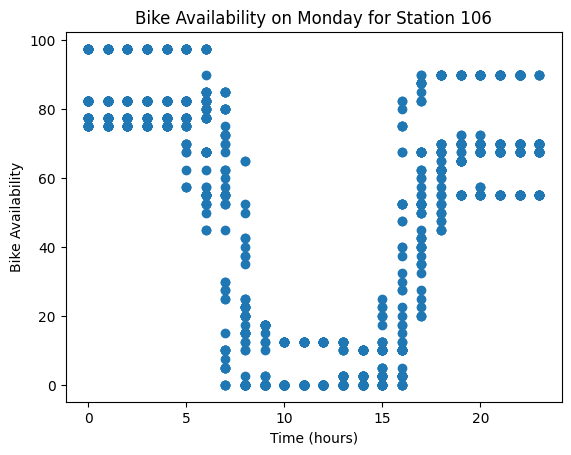

In [40]:
# create scatter plot using the filtered DataFrame
plt.scatter(df_mondays['hour'], df_mondays['availability_percentage'])
plt.title("Bike Availability on Monday for Station 106")
plt.ylabel("Bike Availability")
plt.xlabel("Time (hours)")
plt.show()


In [41]:

def average_bike_availability(numb):
    # filter the DataFrame to only include data for one station
    df_station = df_main.loc[df_main['number'] == numb].copy()
    # set the order of days of the week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # create a new column to map the days of the week to a numerical order
    df_station['day_of_week_order'] = pd.Categorical(df_station['day_of_week'], categories=day_order, ordered=True)
    df_station = df_station.sort_values('day_of_week_order')


    # calculate the mean availability percentage for each hour of the day and day of the week
    df_hourly = df_station.groupby(['day_of_week_order','hour'])['availability_percentage'].mean()
    df_hourly.dropna(inplace=True)

    # plot a line plot of the data
    df_hourly.plot(kind='line', figsize=(10,8))

    plt.title(f"Average Bike Availability for Station {numb} over the Week")
    plt.xlabel("Day of the Week")
    plt.ylabel("Bike Availability")
    plt.ylim(0, 100)
    plt.show()


### Import static bike numbers


In [42]:
# we just need to create a collect csv files for both and put them in here
df_static = pd.read_csv('static_30_3_23.csv')
df_static.head()

,number,contract_name,name,address,position_lat,position_lng,banking,bonus
0,42,dublin,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198,0,0
1,30,dublin,PARNELL SQUARE NORTH,Parnell Square North,53.353742,-6.265301,0,0
2,54,dublin,CLONMEL STREET,Clonmel Street,53.336021,-6.262980,0,0
3,108,dublin,AVONDALE ROAD,Avondale Road,53.359405,-6.276142,0,0
4,20,dublin,JAMES STREET EAST,James Street East,53.336597,-6.248109,0,0


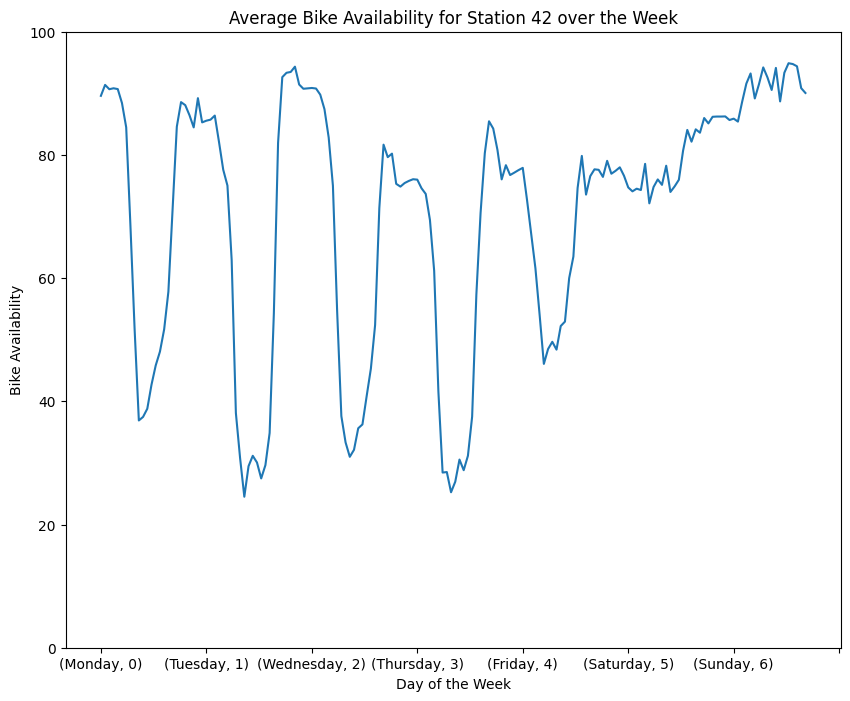

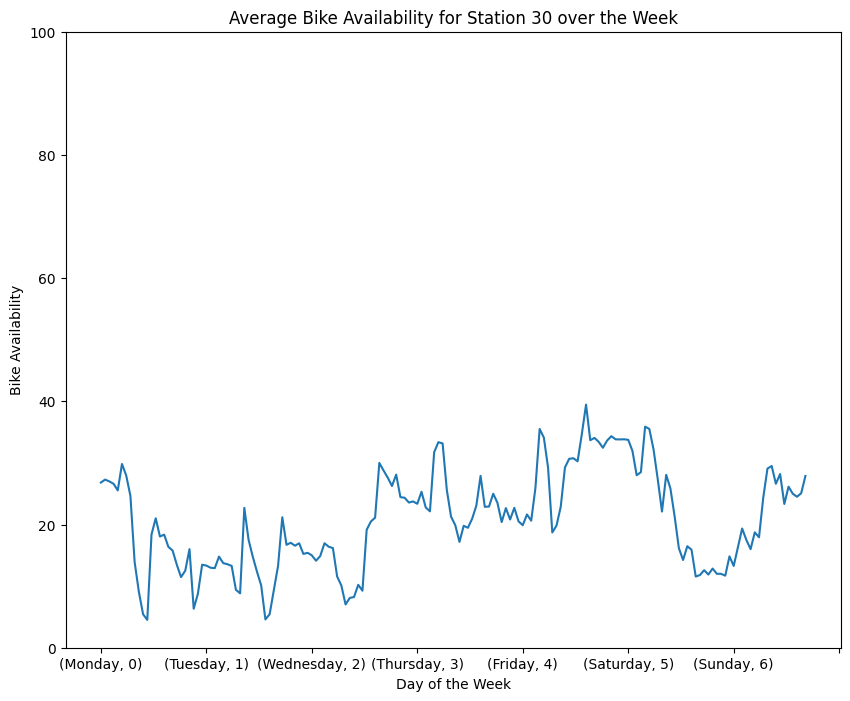

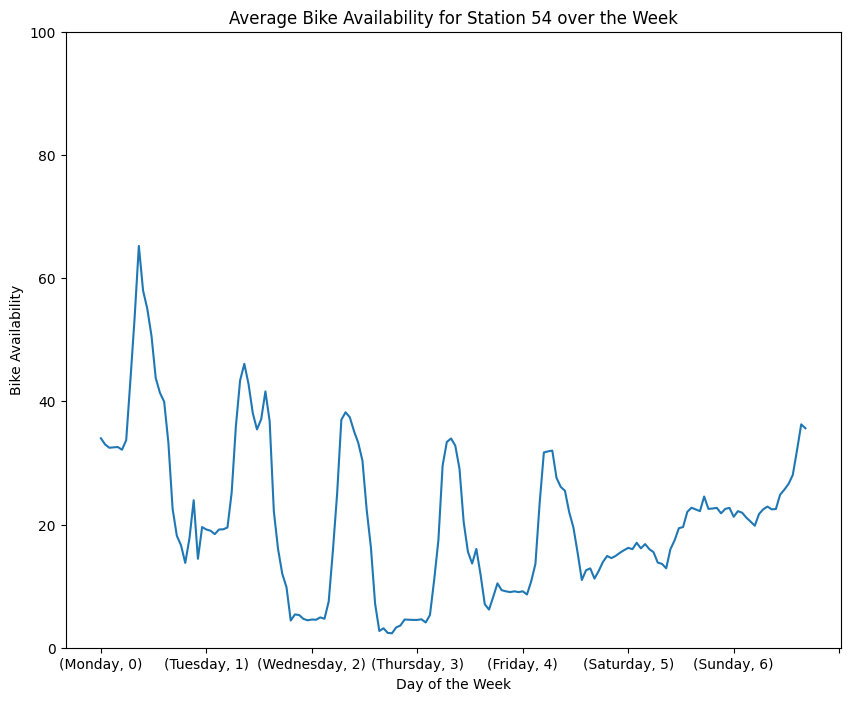

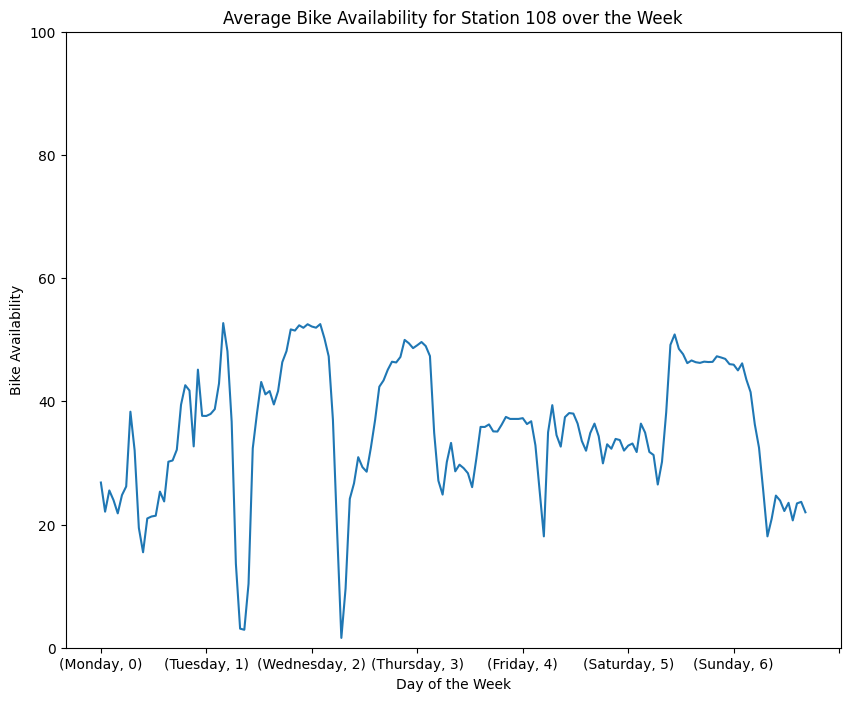

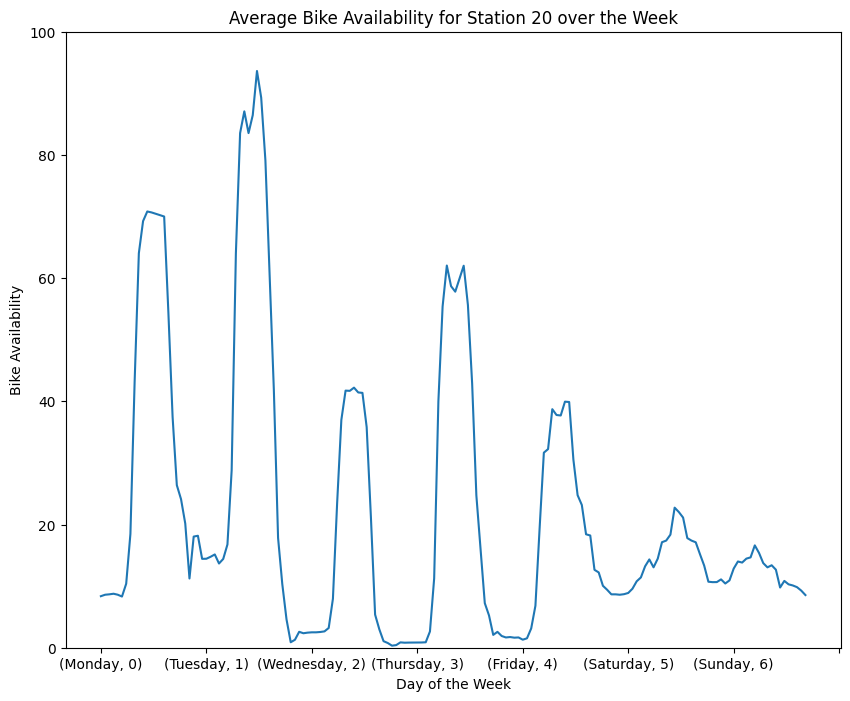

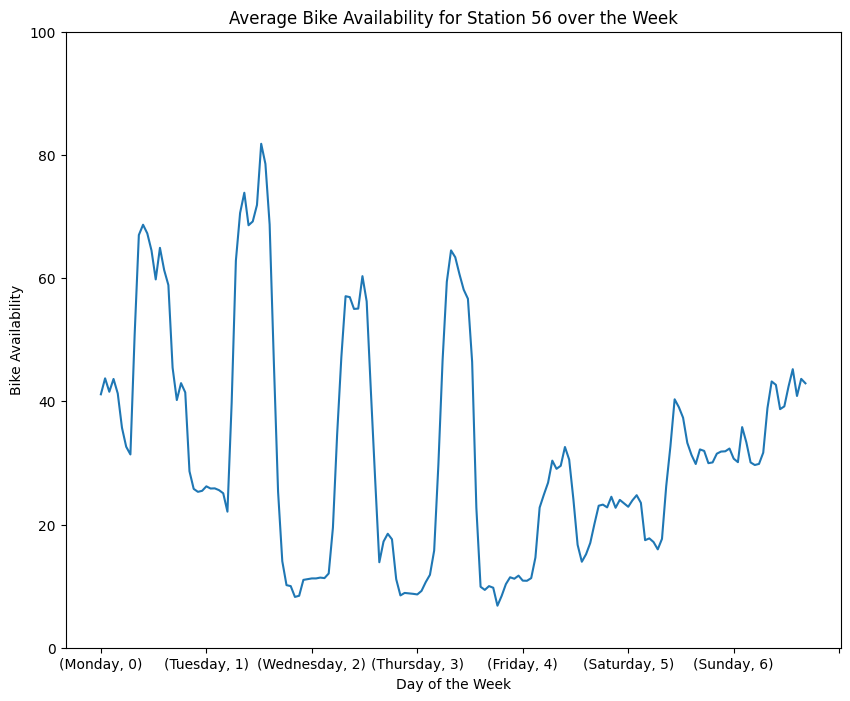

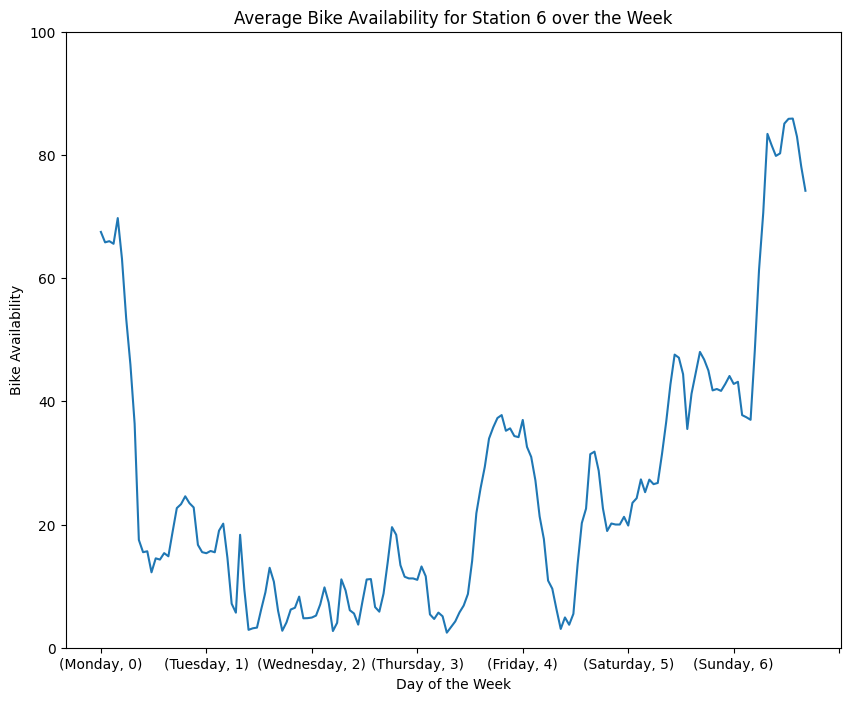

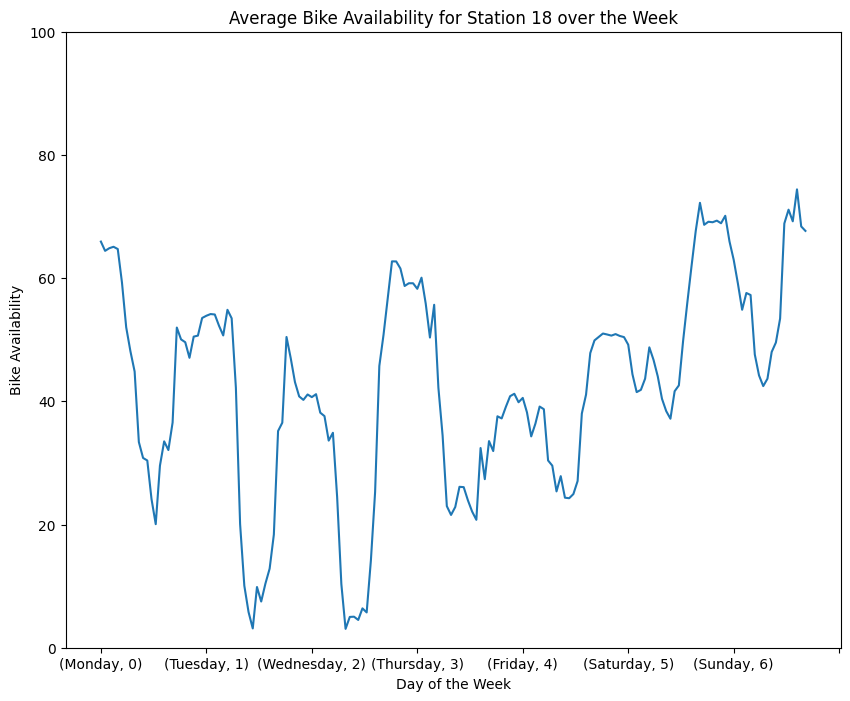

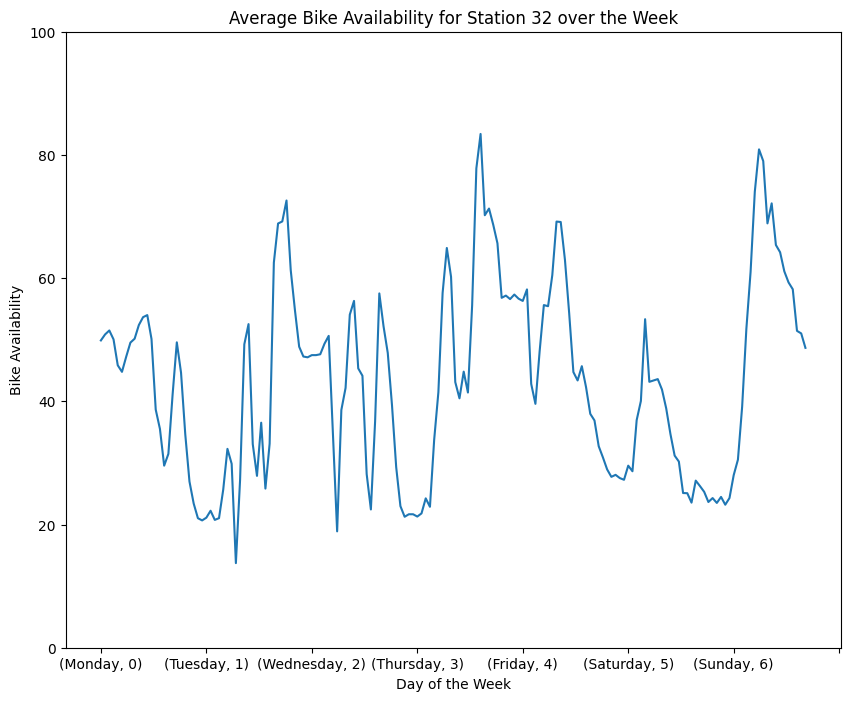

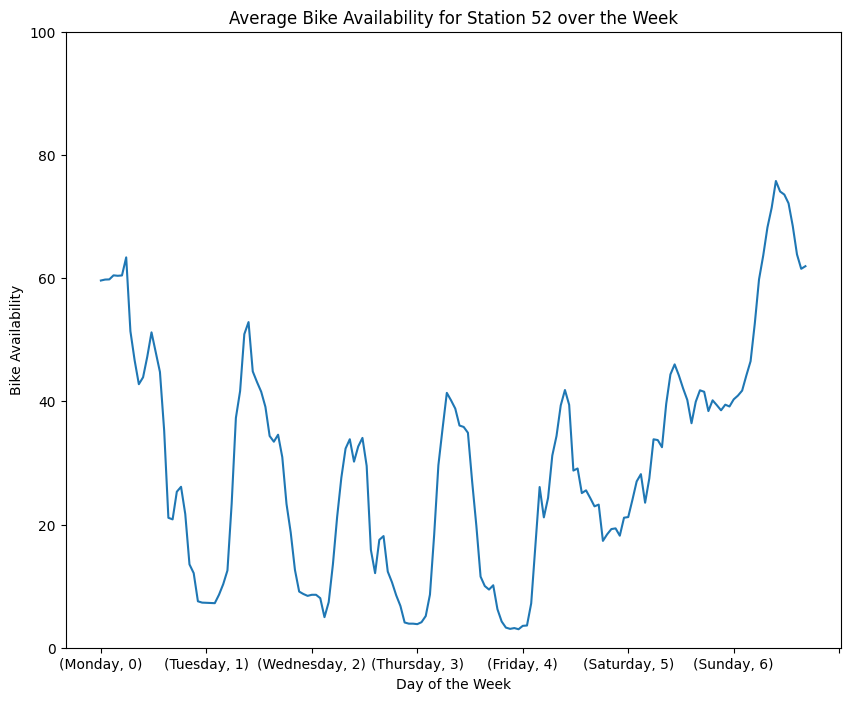

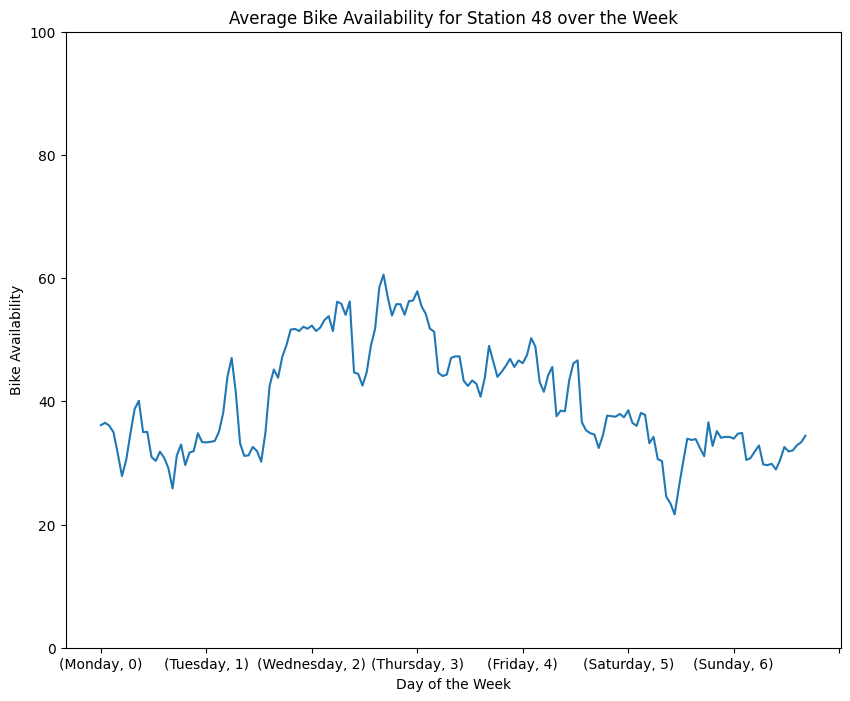

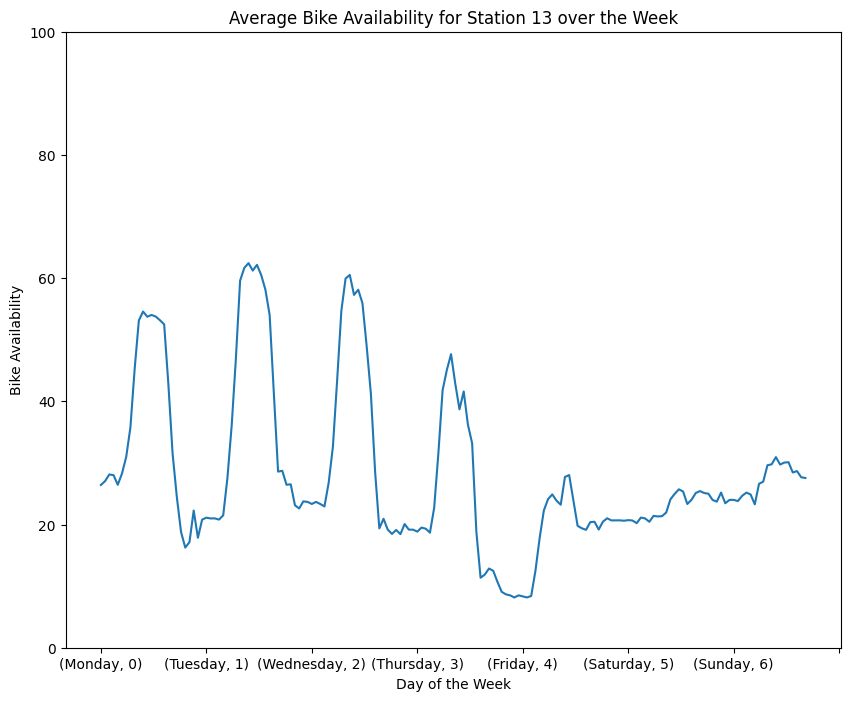

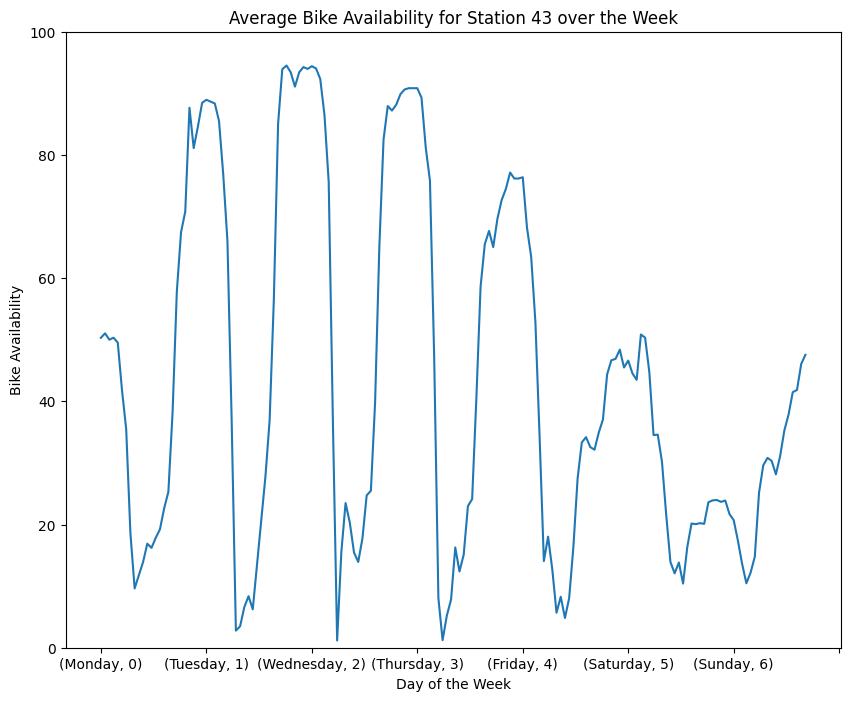

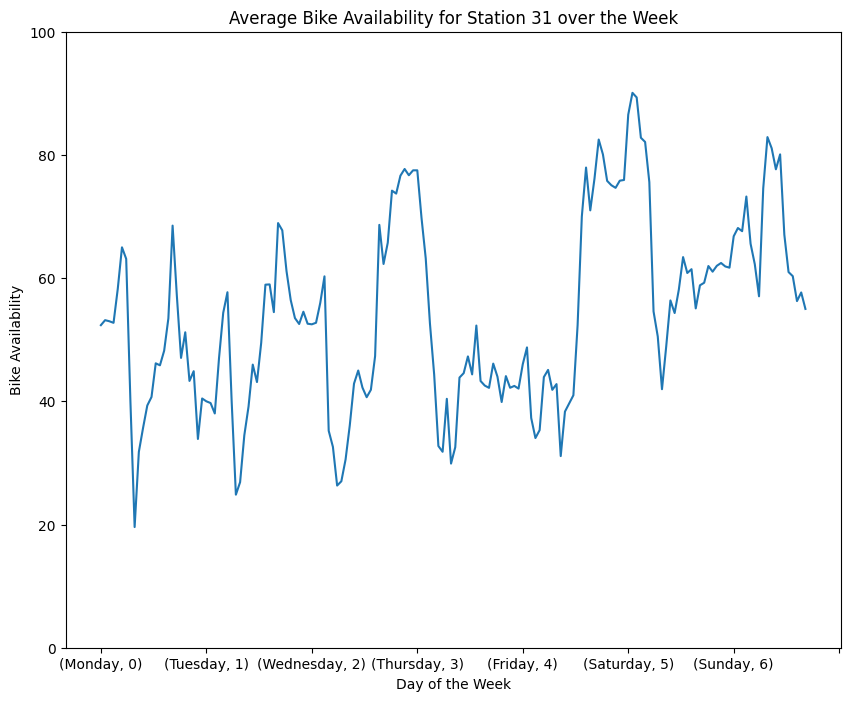

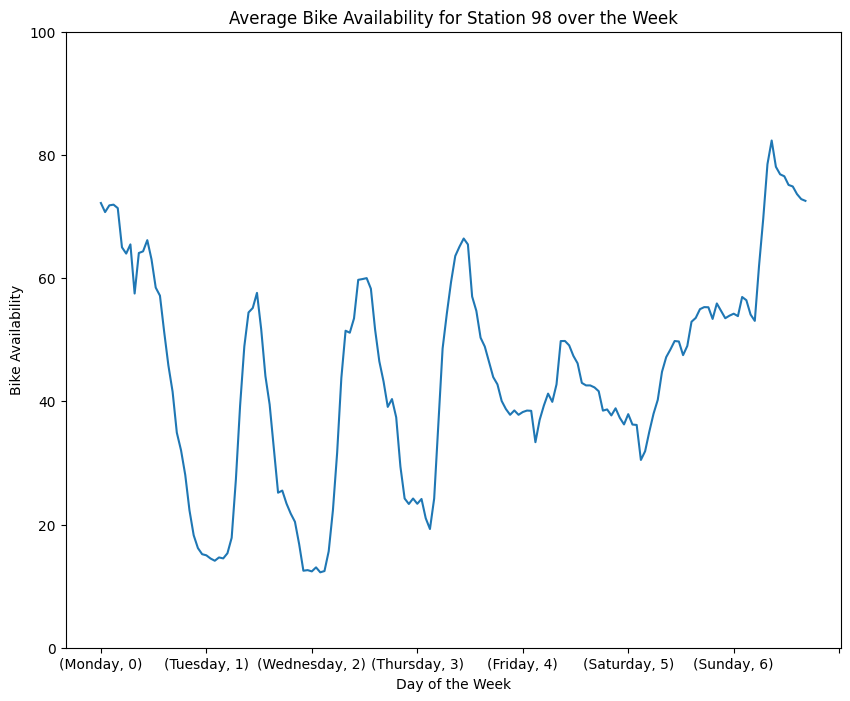

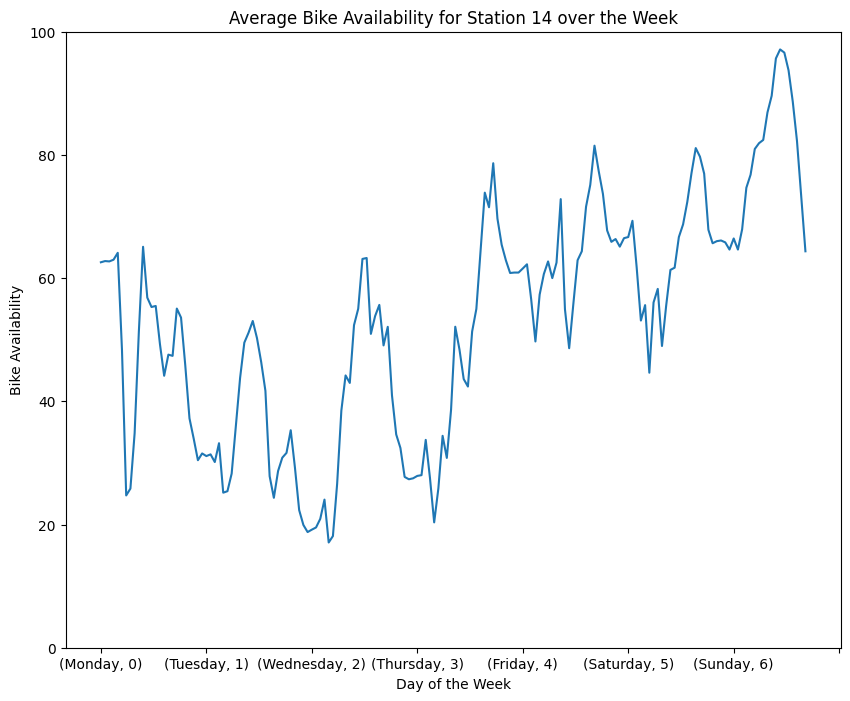

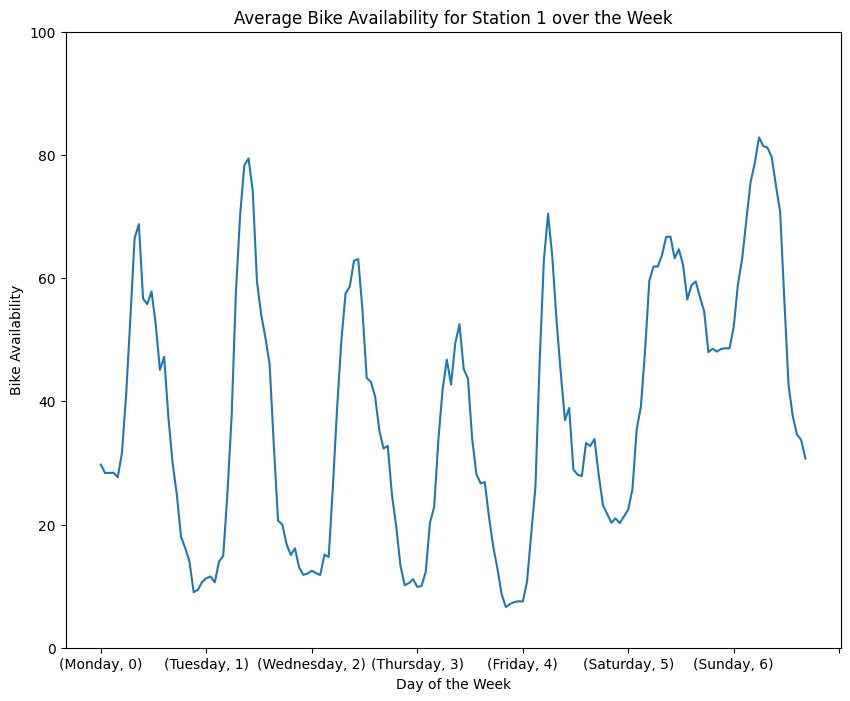

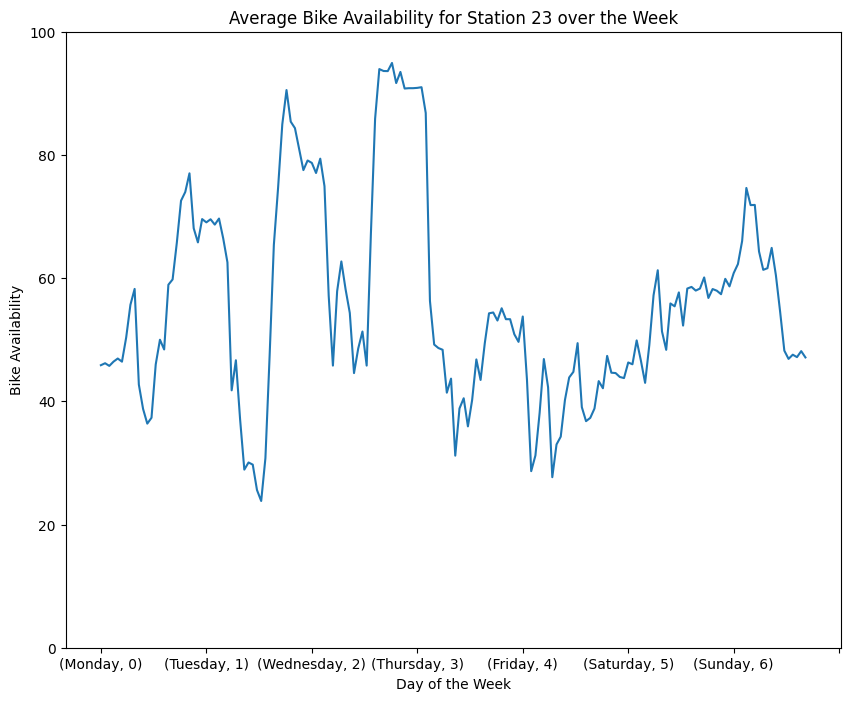

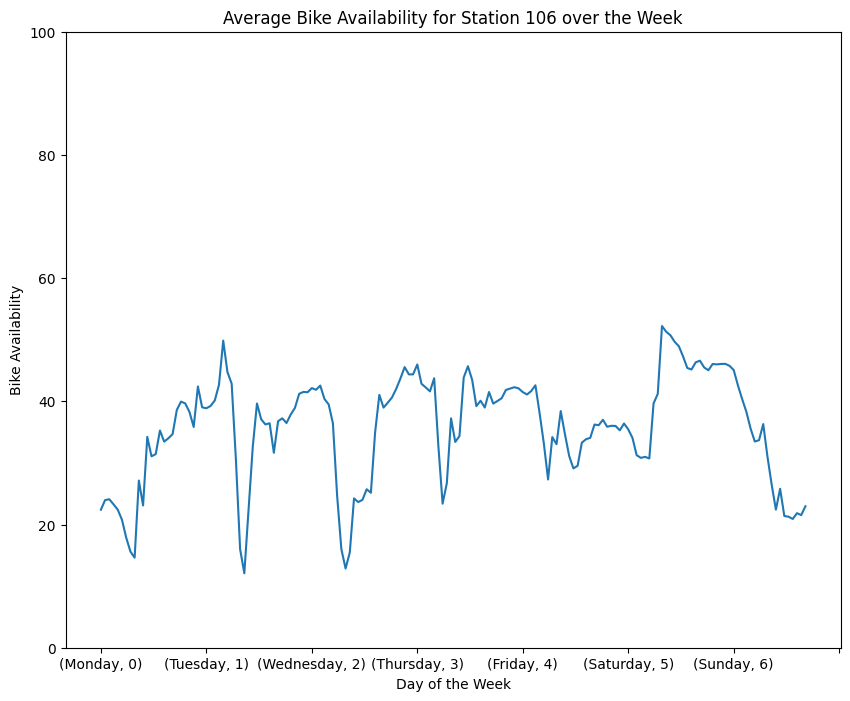

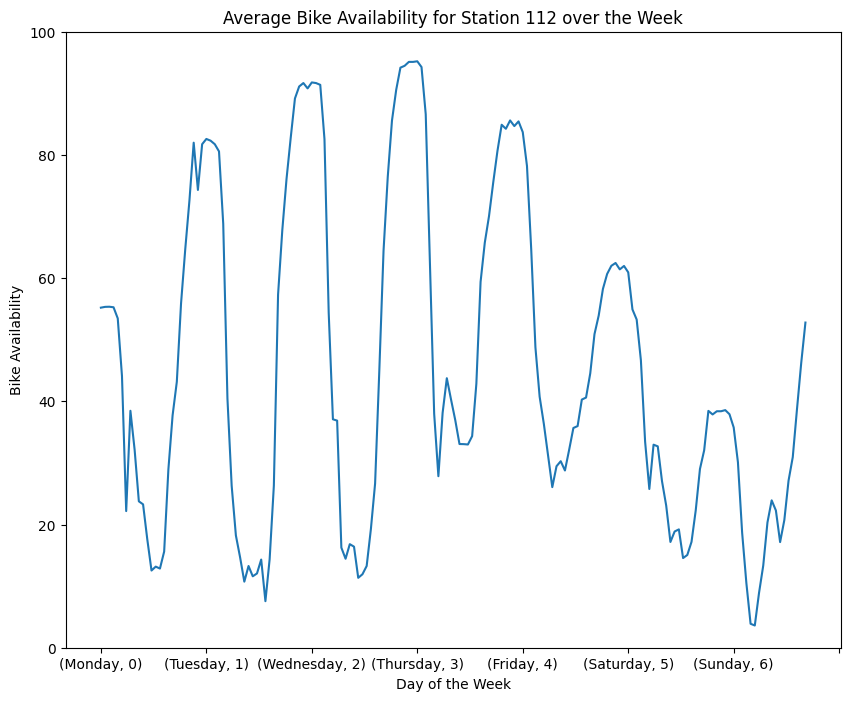

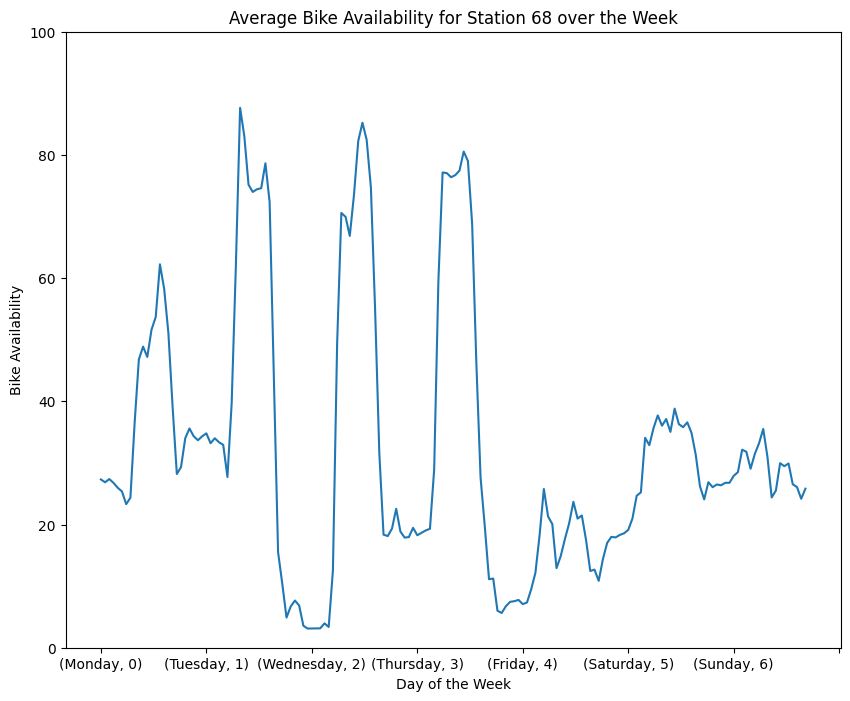

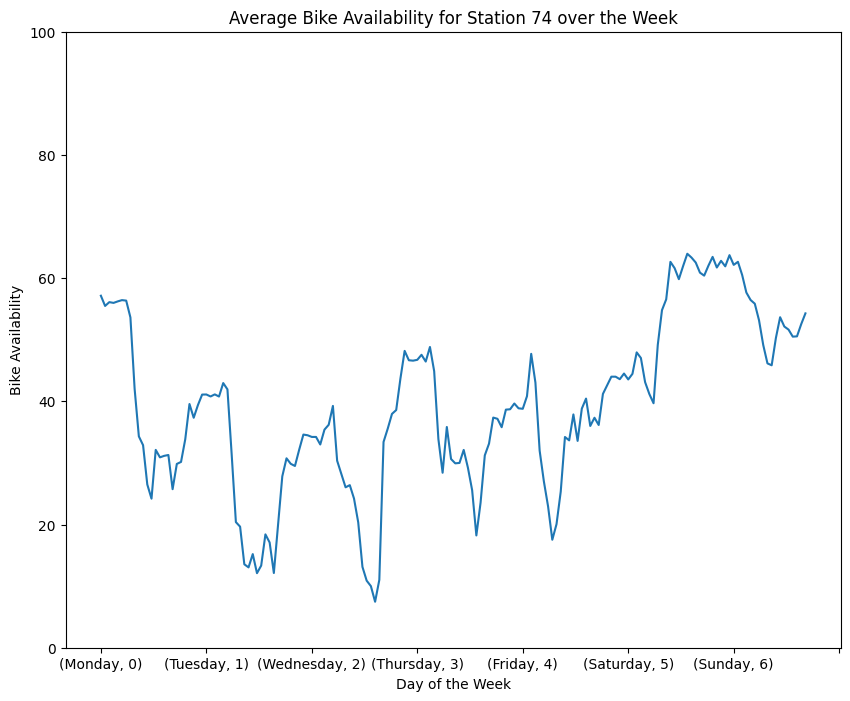

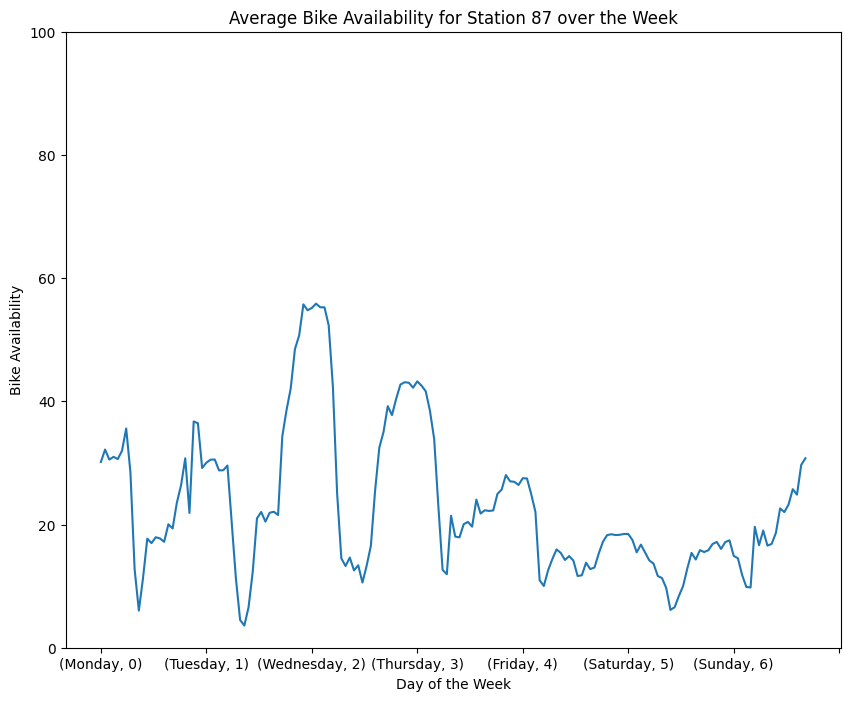

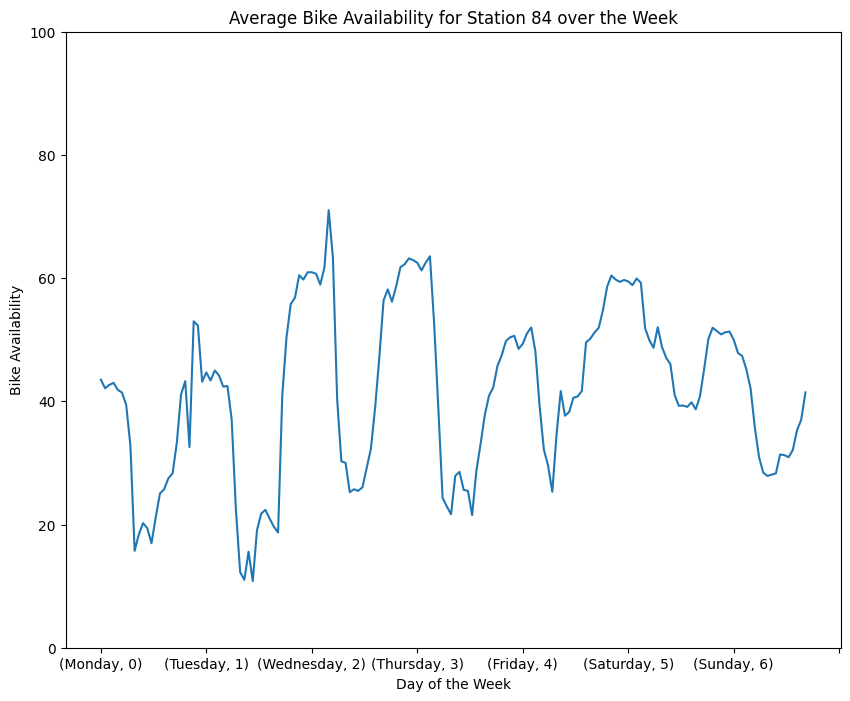

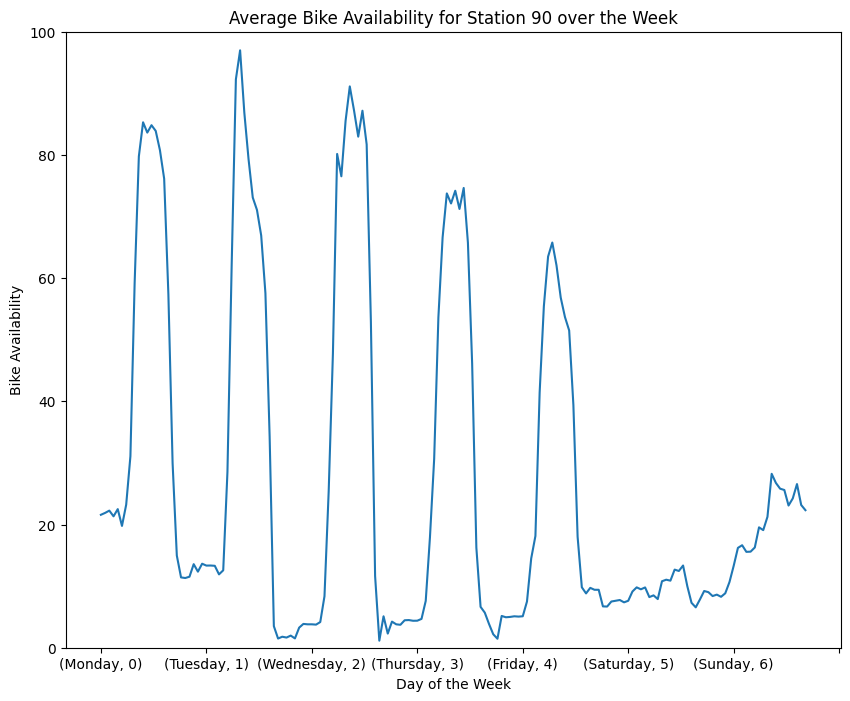

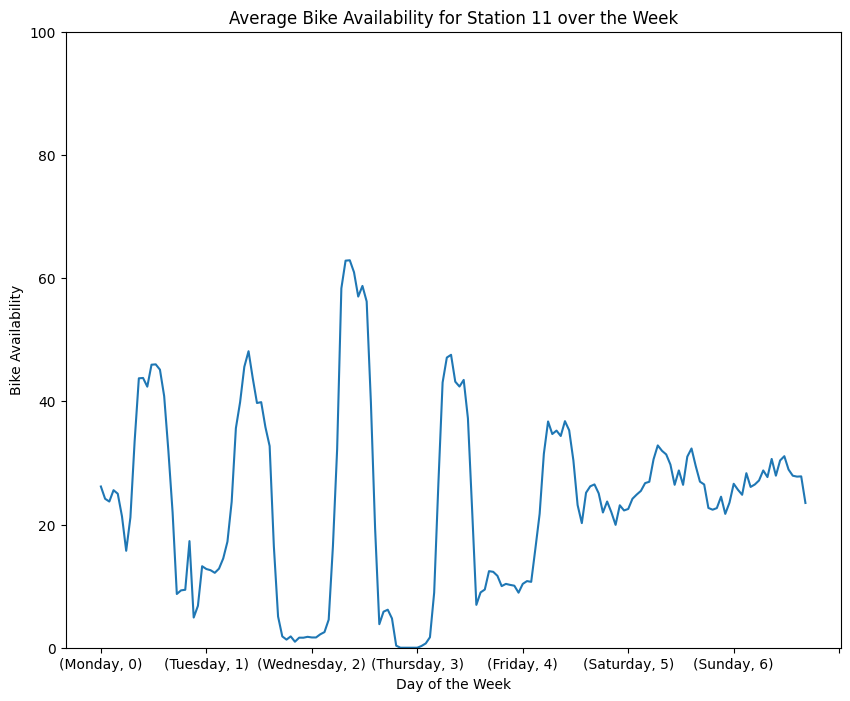

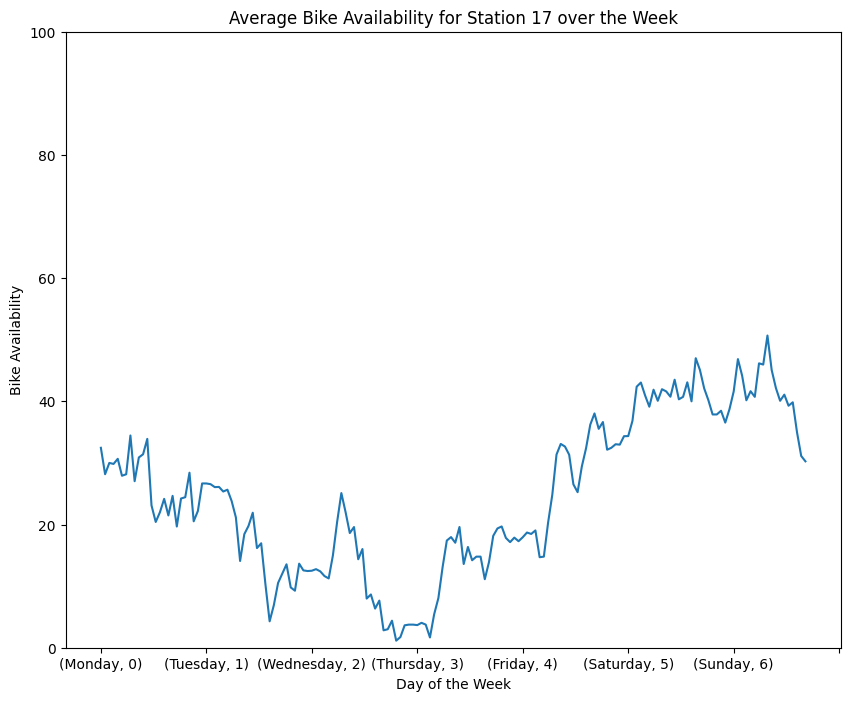

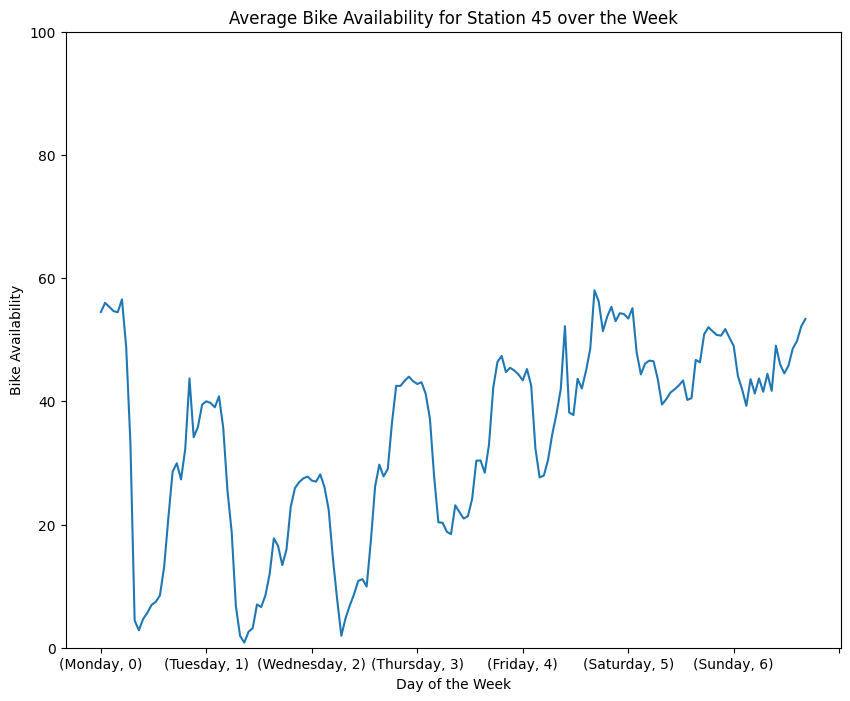

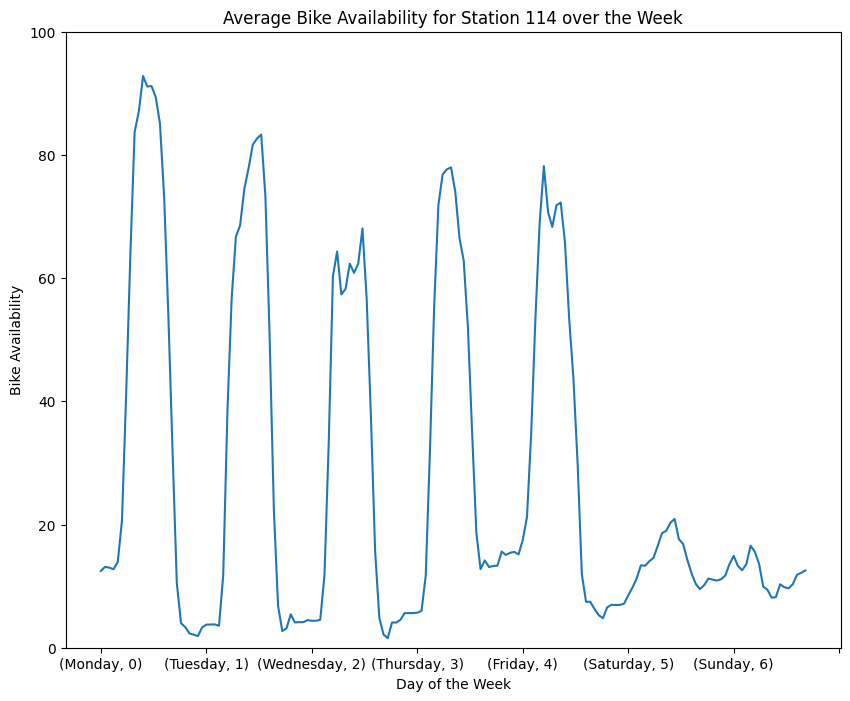

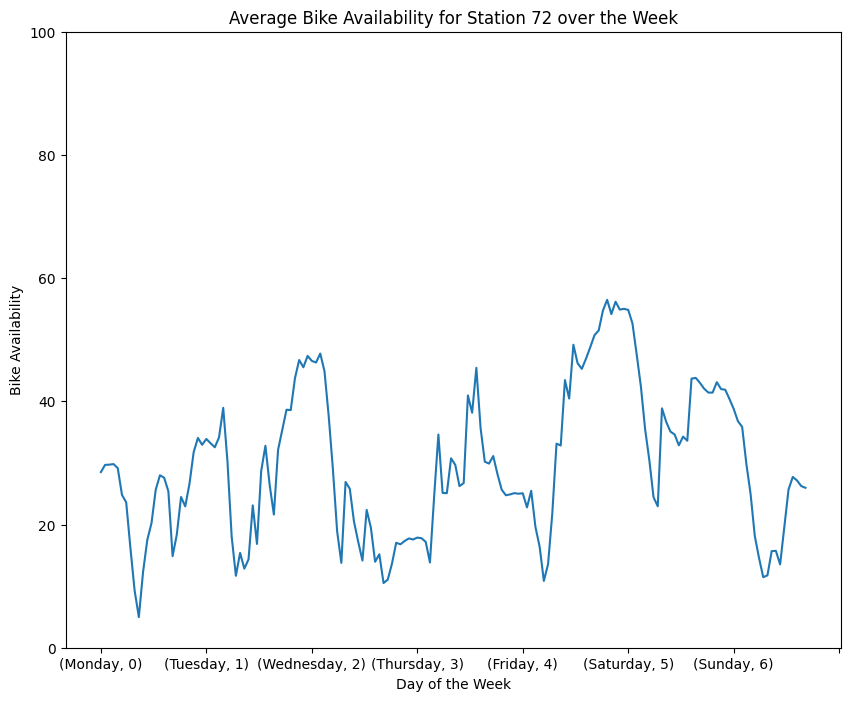

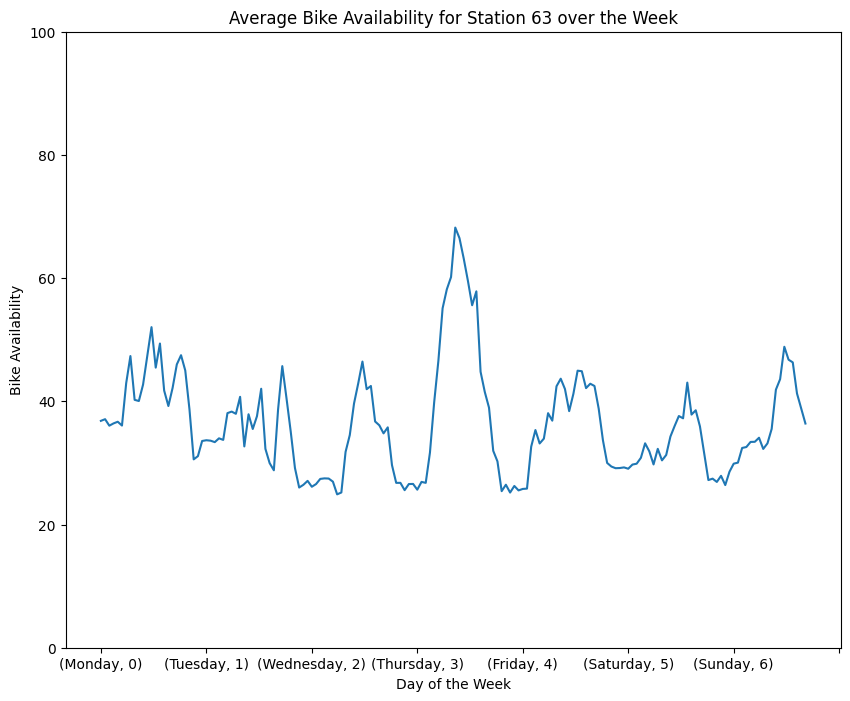

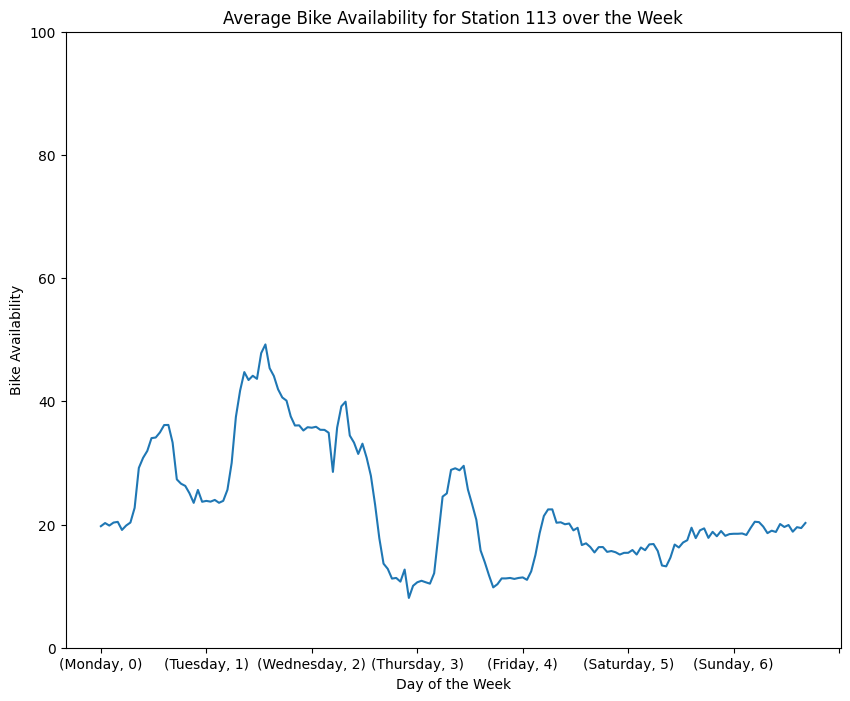

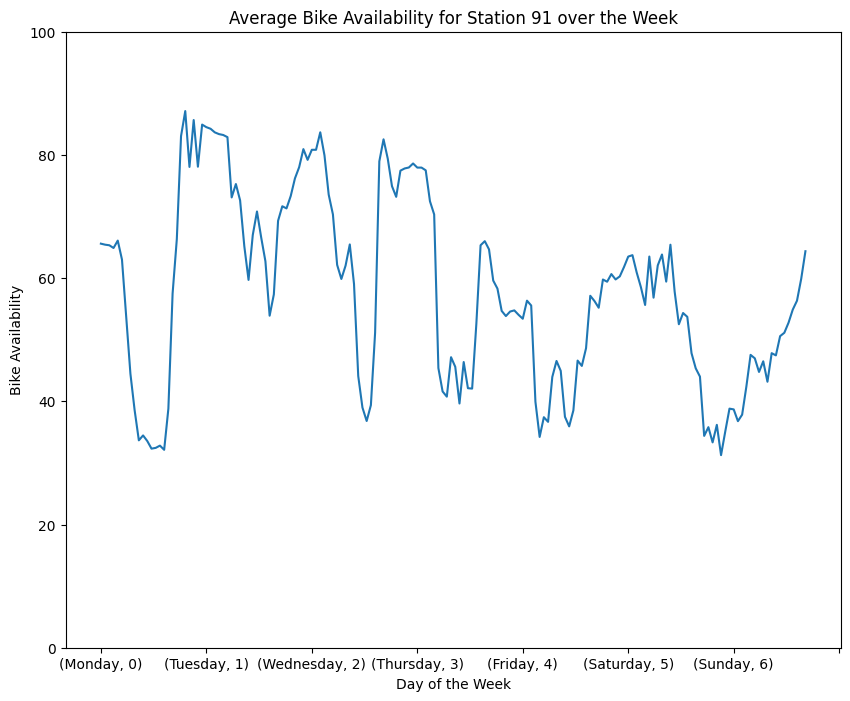

KeyboardInterrupt: 

In [43]:
#pick some stations to plot
length = len(df_static['number'])
for i in range(0, length):
    numb=df_static['number'][i]
    average_bike_availability(numb)

### Conclusion- hours is too granular need more precision?